In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import uproot3
import h5py
import ROOT as rt
from tqdm import tqdm as tqdm
import copy
import math

Welcome to JupyROOT 6.26/10


# Preliminary cuts to skim data !!!
* Acceptance on STRAWs, NewCHOD, CHOD, LAV12, LKr, MUVs
* Minimum 3 STRAW chambers hits
* $p_{tracks}$ > 1 GeV
* $Time_{tracks}\ =\ CHOD\ time\ exist\ ?\ Time_{CHOD}\ :\ Time_{NewCHOD}$ 

# Read skimmed data

In [2]:
dataS = 'diTracks_KsLambda_addMoreDetAssoc_BD2021'
pathS = '/Volumes/Buio/na62/data/diTracks_KsLambda/'
version = '_acceptance'#'_skimmed'
pathPlots = './plotsN/'

In [3]:
pd_read = pd.read_hdf(pathS + dataS + version + '.h5')

In [4]:
pd_read.head()

,RunID,BurstID,EventID,Trigger_Q1,Trigger_H2,Trigger_LKr,TrigSlotQ1_i0,TrigSlotH2_i0,TrigSlotLKr_i0,TrigSlotQ1_i1,...,Track2_HighestNeighbourEnergy,Track2_LKrHitPosition.fX,Track2_LKrHitPosition.fY,Track2_LKrHitPosition.fZ,Track2_LKrHitHighestEPosition.fX,Track2_LKrHitHighestEPosition.fY,Track2_LKrHitHighestEPosition.fZ,Track2_Calorimetric_elec_PID,Track2_Calorimetric_muon_PID,Track2_Calorimetric_pion_PID
entry,,,,,,,,,,,,,,,,,,,,,
1,11061,84,28293,True,True,True,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.989448e-01,0.000782,0.000273
3,11061,84,28711,True,True,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.961763e-11,0.999991,0.000009
5,11061,84,29954,True,True,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.937527e-21,0.996127,0.003873
7,11061,84,31163,True,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.404624e-13,0.999997,0.000003
15,11061,84,34947,True,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.185159e-10,0.999998,0.000002


In [5]:
len(pd_read)

837239

# Selections !!!
* Exclude SR & CR
* Events with minimum 2 downstream tracks
* Events passed L0Calo & H2
* $\chi^{2}_{tracks}$ < 20
* $\chi^{2}_{vertex}$ < 30
* Two tracks have opposite charges
* $\Delta T[Tracks,\ Trigger]$ < 5ns

In [6]:
pd_read['Vertex_pos_R']     = (pd_read['Vertex_pos.fX']**2 + pd_read['Vertex_pos.fY']**2)**(1/2)
pd_read['Vertex_pos.fZ']    = pd_read['Vertex_pos.fZ'].apply(lambda x:x*0.001)

pd_read['Vertex_pos_R_tax'] = (pd_read['Vertex_X_custom']**2 + pd_read['Vertex_Y_custom']**2)**(1/2)
pd_read['Vertex_X_custom']  = pd_read['Vertex_X_custom'].apply(lambda x:x*0.001)
pd_read['Vertex_Y_custom']  = pd_read['Vertex_Y_custom'].apply(lambda x:x*0.001)
pd_read['Vertex_Z_custom']  = pd_read['Vertex_Z_custom'].apply(lambda x:x*0.001)

pd_read['Vertex_tlcda.fX']    = pd_read['Vertex_tlcda.fX'].apply(lambda x:x*0.001)
pd_read['Vertex_tlcda.fY']    = pd_read['Vertex_tlcda.fY'].apply(lambda x:x*0.001)
pd_read['Vertex_tlcda.fZ']    = pd_read['Vertex_tlcda.fZ'].apply(lambda x:x*0.001)

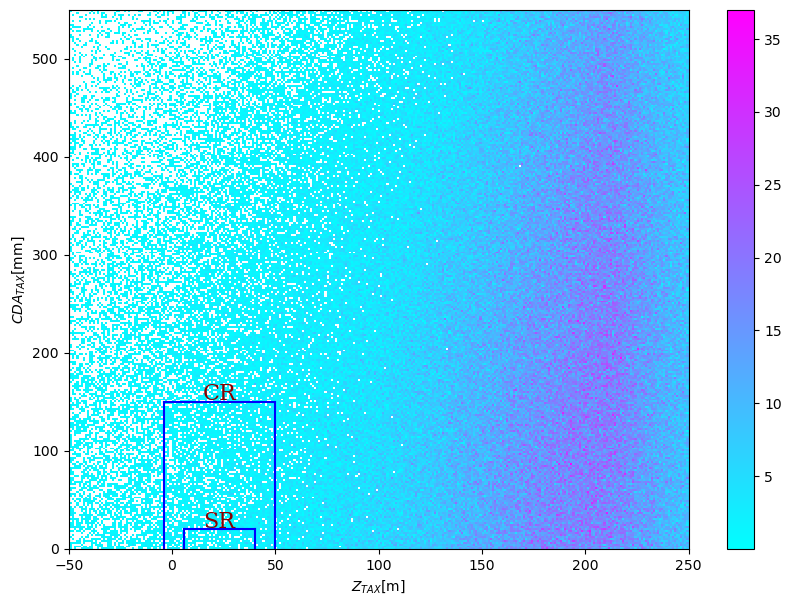

In [7]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('cool'))
cmap.set_under('white')
#cmap = dict(cmap=cmap, vmin=0.000001)
cmap = dict(cmap=cmap, vmin=0.00001)
plt.hist2d(pd_read['Vertex_Z_custom'], pd_read['CDA_tlcda_custom'],bins=(300,275),range=[[-50,250],[0,550]],**cmap,label="All")
#plt.title("")
plt.xlabel('$Z_{TAX}$[m]')
plt.ylabel('$CDA_{TAX}$[mm]')
plt.colorbar()

plt.axhline(y=20,xmin=(50+6)/300, xmax=(50+40)/300, color='blue', linestyle='-')
plt.axvline(x=6,ymax=20/550, color='blue', linestyle='-')
plt.axvline(x=40,ymax=20/550, color='blue', linestyle='-')

plt.axhline(y=150,xmin=(50-4)/300, xmax=(50+50)/300, color='blue', linestyle='-')
plt.axvline(x=-4,ymax=150/550, color='blue', linestyle='-')
plt.axvline(x=50,ymax=150/550, color='blue', linestyle='-')

font = {'family': 'serif', 'color':  'darkred', 'weight': 'normal', 'size': 16}
plt.text(23, 152, "CR", fontdict=font,rotation='horizontal',ha='center')
plt.text(23, 21, "SR", fontdict=font,rotation='horizontal',ha='center')

plt.savefig(pathPlots + "ZtaxVsCDAtax.png",bbox_inches='tight')

In [8]:
upCR = (pd_read['CDA_tlcda_custom']>150) & (pd_read['Vertex_Z_custom'] > -4) & (pd_read['Vertex_Z_custom'] < 50)
sideCR = (pd_read['Vertex_Z_custom'] < -4) | (pd_read['Vertex_Z_custom'] > 50)
pd_outCR = pd_read[upCR | sideCR]

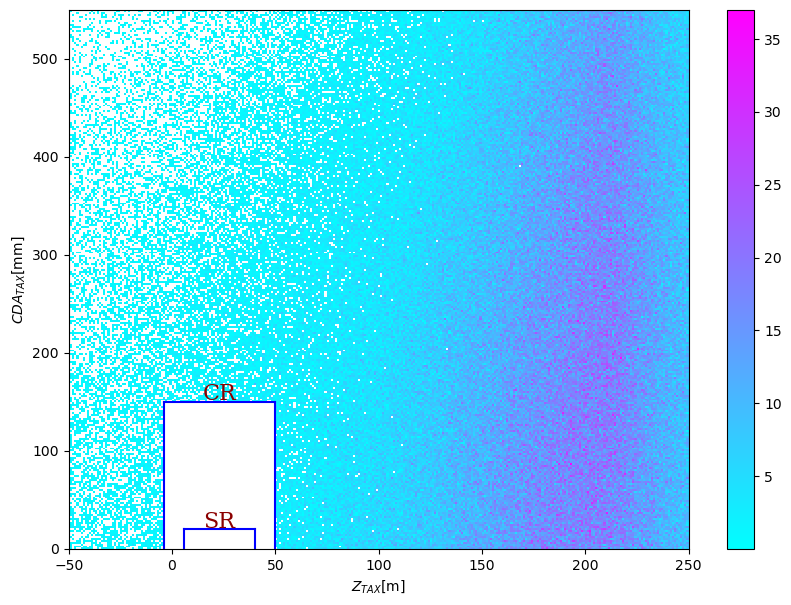

In [9]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('cool'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=0.00001)
plt.hist2d(pd_outCR['Vertex_Z_custom'], pd_outCR['CDA_tlcda_custom'],bins=(300,275),range=[[-50,250],[0,550]],**cmap,label="All")
plt.xlabel('$Z_{TAX}$[m]')
plt.ylabel('$CDA_{TAX}$[mm]')
plt.colorbar()

plt.axhline(y=20,xmin=(50+6)/300, xmax=(50+40)/300, color='blue', linestyle='-')
plt.axvline(x=6,ymax=20/550, color='blue', linestyle='-')
plt.axvline(x=40,ymax=20/550, color='blue', linestyle='-')

plt.axhline(y=150,xmin=(50-4)/300, xmax=(50+50)/300, color='blue', linestyle='-')
plt.axvline(x=-4,ymax=150/550, color='blue', linestyle='-')
plt.axvline(x=50,ymax=150/550, color='blue', linestyle='-')

font = {'family': 'serif', 'color':  'darkred', 'weight': 'normal', 'size': 16}
plt.text(23, 152, "CR", fontdict=font,rotation='horizontal',ha='center')
plt.text(23, 21, "SR", fontdict=font,rotation='horizontal',ha='center')

plt.savefig(pathPlots + "ZtaxVsCDAtax_outOfCR.png",bbox_inches='tight')

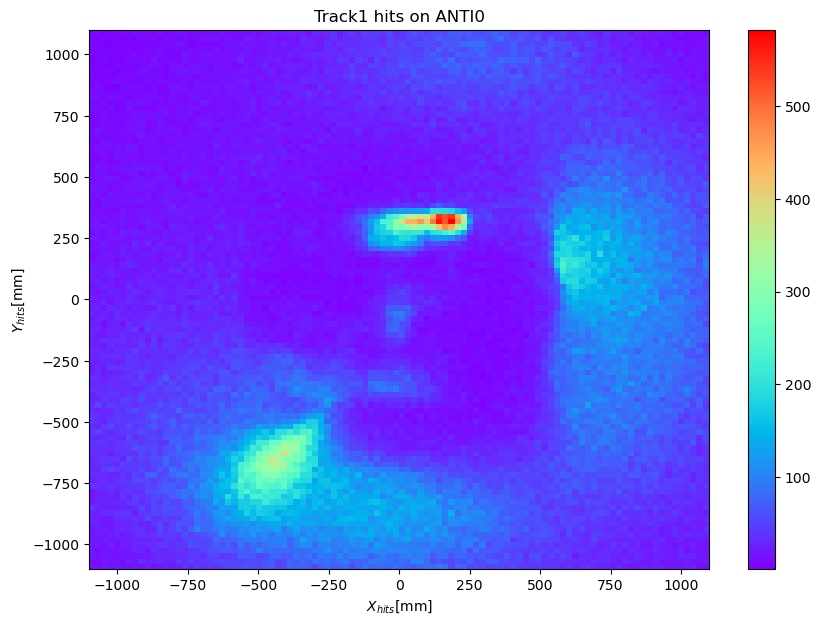

In [10]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(pd_outCR['Track1_posANTI0.fX'], pd_outCR['Track1_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track1 hits on ANTI0")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk1_hitsOnANTI0.png",bbox_inches='tight')

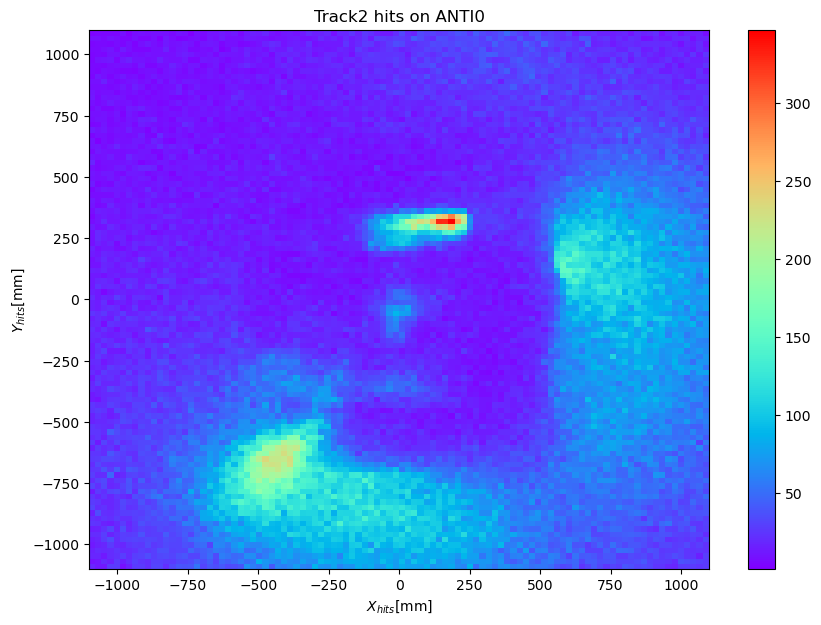

In [11]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(pd_outCR['Track2_posANTI0.fX'], pd_outCR['Track2_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track2 hits on ANTI0")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk2_hitsOnANTI0.png",bbox_inches='tight')

In [12]:
Trigger_Selection = (pd_outCR['Trigger_LKr']==True) & (pd_outCR['Trigger_H2']==True)
Baseline_Selection = (pd_outCR['Track1_nChambers'] >2) & (pd_outCR['Track2_nChambers'] >2) & (pd_outCR['Track1_chi2']<20) & (pd_outCR['Track2_chi2']<20) & (pd_outCR['Vertex_Chi2']<30)
#Baseline_Selection = Baseline_Selection & (pd_outCR['Track1_MUV1AssociationExists']==True) & (pd_outCR['Track1_MUV2AssociationExists']==True)
#Baseline_Selection = Baseline_Selection & (pd_outCR['Track2_MUV1AssociationExists']==True) & (pd_outCR['Track2_MUV2AssociationExists']==True)
acc_ANTI0 = (pd_outCR['Track1_accANTI0']) & (pd_outCR['Track2_accANTI0'])

In [13]:
#data_skimmed = pd_outCR[Trigger_Selection & Detector_acceptance_trk1 & Detector_acceptance_trk2 & Baseline_Selection]
data_skimmed = pd_outCR[Trigger_Selection & Baseline_Selection]

In [14]:
len(data_skimmed)

51420

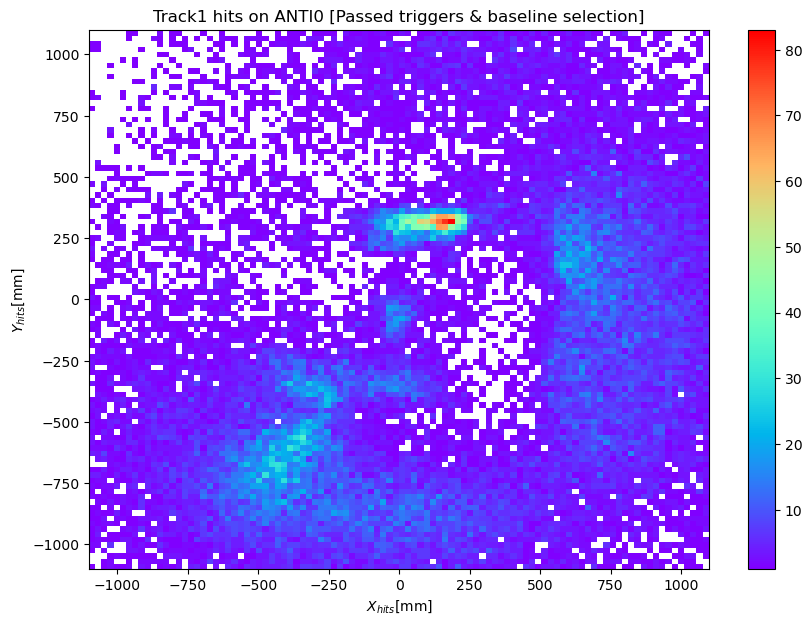

In [15]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_skimmed['Track1_posANTI0.fX'], data_skimmed['Track1_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track1 hits on ANTI0 [Passed triggers & baseline selection]")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk1_hitsOnANTI0_baseline.png",bbox_inches='tight')

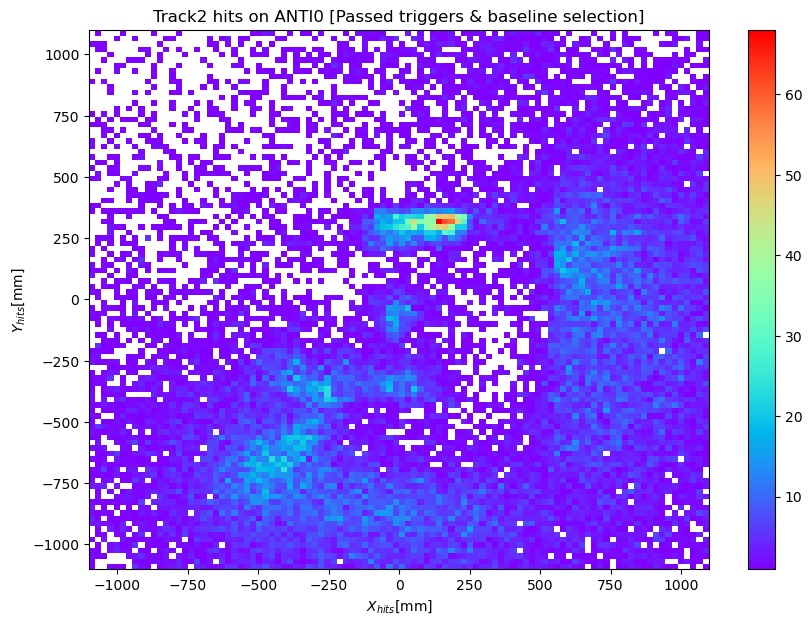

In [16]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_skimmed['Track2_posANTI0.fX'], data_skimmed['Track2_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track2 hits on ANTI0 [Passed triggers & baseline selection]")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk2_hitsOnANTI0_baseline.png",bbox_inches='tight')

In [17]:
charge_TrkTrk = (data_skimmed['Track1_charge']) + (data_skimmed['Track2_charge'])
data_os = data_skimmed[charge_TrkTrk==0]

In [18]:
len(data_os)

51420

In [19]:
data_os['Vertex_pos_R']     = data_os['Vertex_pos_R'].apply(lambda x:x*0.001)
data_os['Vertex_pos_R_tax'] = data_os['Vertex_pos_R_tax'].apply(lambda x:x*0.001)

In [20]:
data_os['Track1_3Momenta.fX'] = data_os['Track1_3Momenta.fX'].apply(lambda x:x*0.001)
data_os['Track1_3Momenta.fY'] = data_os['Track1_3Momenta.fY'].apply(lambda x:x*0.001)
data_os['Track1_3Momenta.fZ'] = data_os['Track1_3Momenta.fZ'].apply(lambda x:x*0.001)
data_os['Track2_3Momenta.fX'] = data_os['Track2_3Momenta.fX'].apply(lambda x:x*0.001)
data_os['Track2_3Momenta.fY'] = data_os['Track2_3Momenta.fY'].apply(lambda x:x*0.001)
data_os['Track2_3Momenta.fZ'] = data_os['Track2_3Momenta.fZ'].apply(lambda x:x*0.001)

In [21]:
data_os.loc[:, 'pi1_CHANTI']  = data_os['Track1_CHANTIAssociationExists']
data_os.loc[:, 'pi2_CHANTI']  = data_os['Track2_CHANTIAssociationExists']

data_os.loc[:, 'pi1_ANTI0']  = data_os['Track1_ANTI0AssociationExists']
data_os.loc[:, 'pi2_ANTI0']  = data_os['Track2_ANTI0AssociationExists']

data_os.loc[:, 'pi1_NewCHOD']  = data_os['Track1_NewCHODAssociationExists']
data_os.loc[:, 'pi2_NewCHOD']  = data_os['Track2_NewCHODAssociationExists']

data_os.loc[:, 'pi1_LKr']      = data_os['Track1_LKrAssociationExists']
data_os.loc[:, 'pi2_LKr']      = data_os['Track2_LKrAssociationExists']

data_os.loc[:, 'pi1_MUV1']     = data_os['Track1_MUV1AssociationExists']
data_os.loc[:, 'pi2_MUV1']     = data_os['Track2_MUV1AssociationExists']

data_os.loc[:, 'pi1_MUV2']     = data_os['Track1_MUV2AssociationExists']
data_os.loc[:, 'pi2_MUV2']     = data_os['Track2_MUV2AssociationExists']

data_os.loc[:, 'pi1_MUV3']     = data_os['Track1_MUV3AssociationExists']
data_os.loc[:, 'pi2_MUV3']     = data_os['Track2_MUV3AssociationExists']

In [22]:
data_os.loc[acc_ANTI0==True,  'acc_ANTI0'] = True
data_os.loc[acc_ANTI0==False, 'acc_ANTI0'] = False

In [23]:
data_os.loc[data_os['Track1_CHODTimeExist']==True, 'trk1_time']   = data_os['Track1_CHODTime']
data_os.loc[data_os['Track2_CHODTimeExist']==True, 'trk2_time']   = data_os['Track2_CHODTime']
data_os.loc[data_os['Track1_CHODTimeExist']==False, 'trk1_time']  = data_os['Track1_NewCHODTime']
data_os.loc[data_os['Track2_CHODTimeExist']==False, 'trk2_time']  = data_os['Track2_NewCHODTime']

In [24]:
data_os.loc[:, 'deltaT_trk1'] = abs(data_os['trk1_time'] - data_os['Trigger_Time'])
data_os.loc[:, 'deltaT_trk2'] = abs(data_os['trk2_time'] - data_os['Trigger_Time'])

In [25]:
data_os.loc[:, 'deltaT_trk12'] = abs(data_os['deltaT_trk1'] - data_os['deltaT_trk2'])

In [26]:
data_os = data_os[(data_os['deltaT_trk1']<5) & (data_os['deltaT_trk2']<5)]

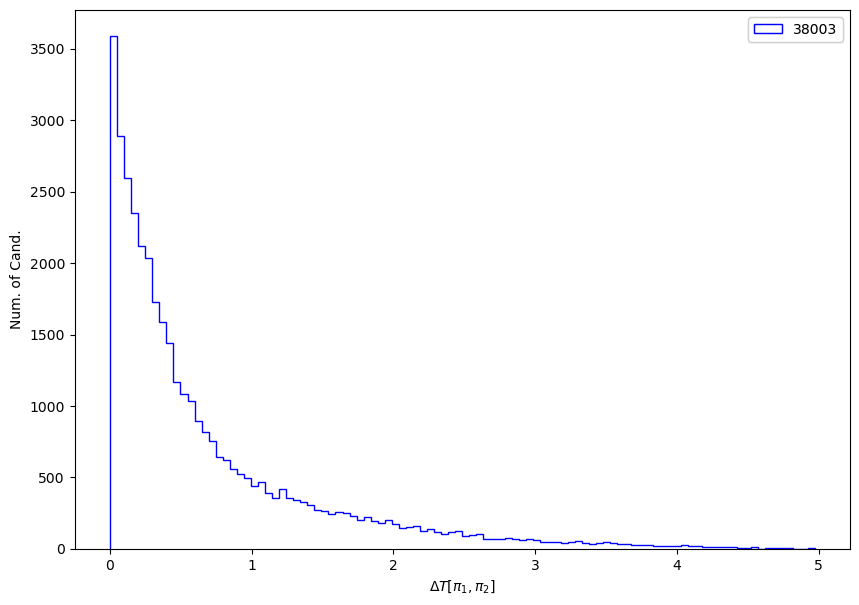

In [27]:
plt.figure(figsize=(10,7))
plt.hist(data_os['deltaT_trk12'],bins=100,log=False,label="", color='blue', histtype='step')
plt.title("")
plt.xlabel('$\Delta T[\pi_{1},\pi_{2}]$')
plt.ylabel('Num. of Cand.')
npipi = data_os['deltaT_trk12']
npipi = str(len(npipi))
legend1 = plt.legend([npipi],loc=1)
plt.gca().add_artist(legend1)
plt.savefig(pathPlots + "deltaT_trk12.png",bbox_inches='tight')

In [28]:
data_os = data_os[data_os['deltaT_trk12']<1.5]

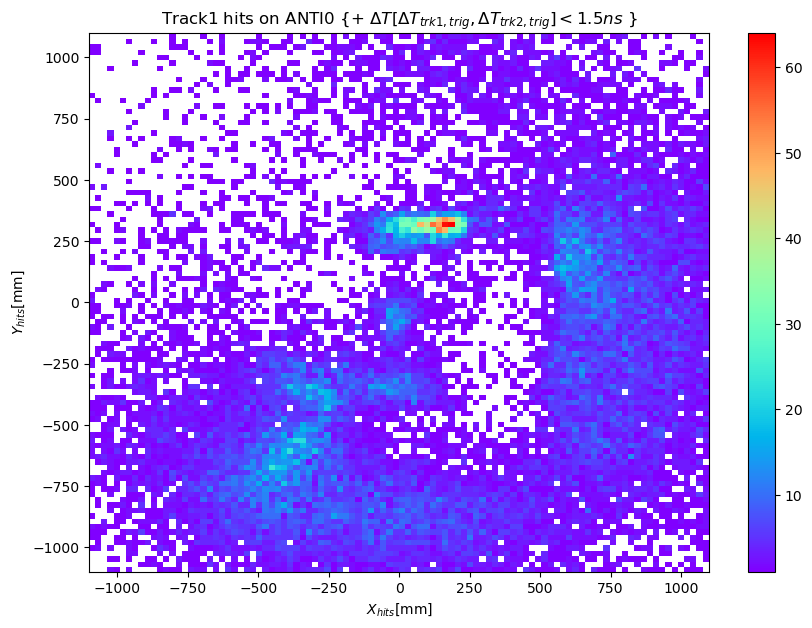

In [29]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os['Track1_posANTI0.fX'], data_os['Track1_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track1 hits on ANTI0 {+ $\Delta T[\Delta T_{trk1,trig},\Delta T_{trk2,trig}] < 1.5ns$ }")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk1_hitsOnANTI0_dT12.png",bbox_inches='tight')

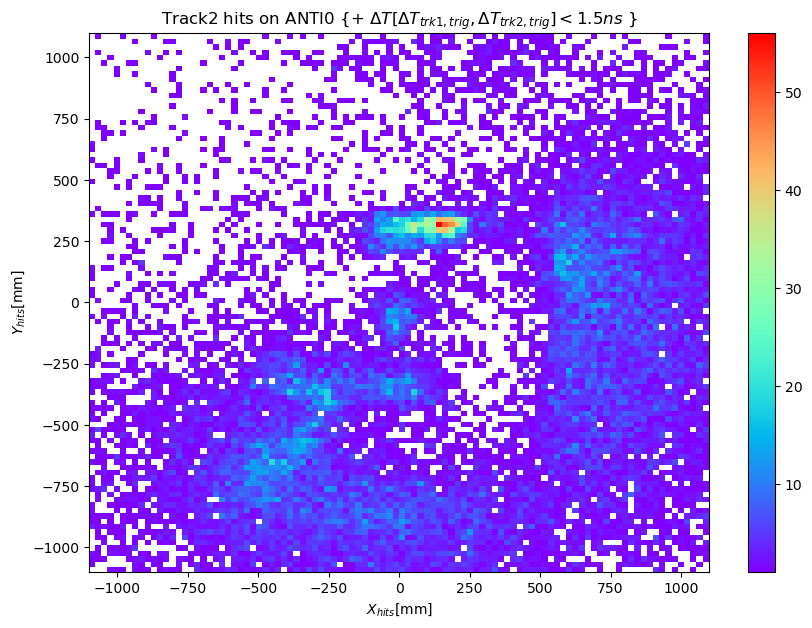

In [30]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os['Track2_posANTI0.fX'], data_os['Track2_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track2 hits on ANTI0 {+ $\Delta T[\Delta T_{trk1,trig},\Delta T_{trk2,trig}] < 1.5ns$ }")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk2_hitsOnANTI0_dT12.png",bbox_inches='tight')

# $E_{LKr}/p\ vs\ p$

/var/folders/v0/m2n9p37j619fdss_7fv_5k700000gn/T/ipykernel_49600/1588735215.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.hist2d(data_os['Track1_p'], data_os['Track1_lkrEoP'],bins=100,range=[[0,400],[0,1.2]],norm=mcolors.LogNorm(),**cmap,label="All")


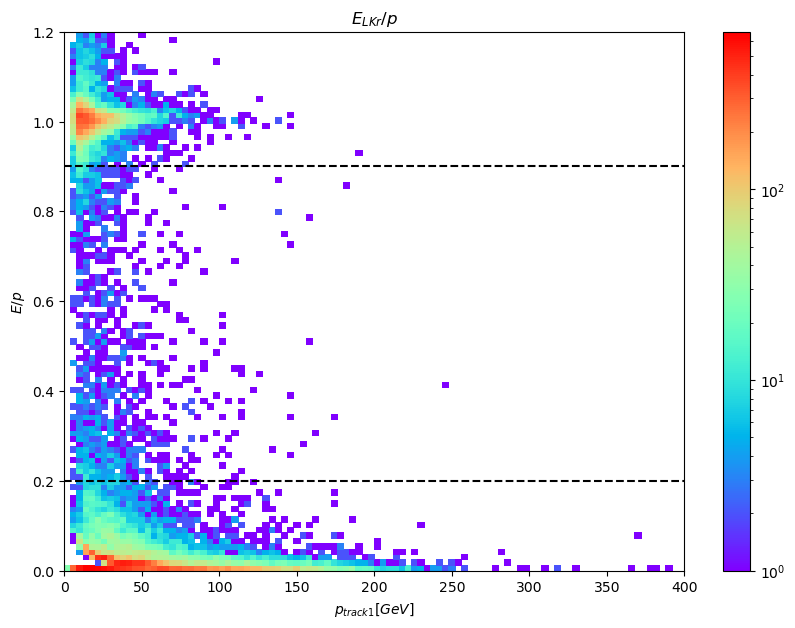

In [31]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os['Track1_p'], data_os['Track1_lkrEoP'],bins=100,range=[[0,400],[0,1.2]],norm=mcolors.LogNorm(),**cmap,label="All")
plt.title("$E_{LKr}/p$")
plt.xlabel('$p_{track1}[GeV]$')
plt.ylabel('$E/p$')
plt.colorbar()
plt.axhline(y=0.9, color='black', linestyle='--')
plt.axhline(y=0.2, color='black', linestyle='--')
plt.savefig(pathPlots + "Trk1_LKrEoP.png",bbox_inches='tight')

/var/folders/v0/m2n9p37j619fdss_7fv_5k700000gn/T/ipykernel_49600/2944492866.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.hist2d(data_os['Track2_p'], data_os['Track2_lkrEoP'],bins=100,range=[[0,400],[0,1.2]],label="$N_{tracks}$",norm=mcolors.LogNorm(),**cmap)


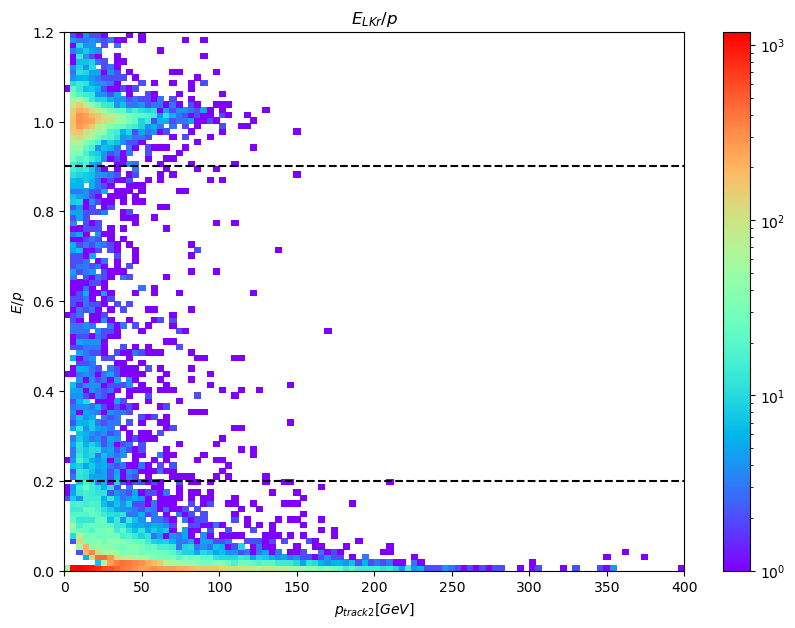

In [32]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os['Track2_p'], data_os['Track2_lkrEoP'],bins=100,range=[[0,400],[0,1.2]],label="$N_{tracks}$",norm=mcolors.LogNorm(),**cmap)
plt.title("$E_{LKr}/p$")
plt.xlabel('$p_{track2}[GeV]$')
plt.ylabel('$E/p$')
plt.colorbar()
plt.axhline(y=0.9, color='black', linestyle='--')
plt.axhline(y=0.2, color='black', linestyle='--')
plt.savefig(pathPlots + "Trk2_LKrEoP.png",bbox_inches='tight')

In [33]:
piMass = 0.13957039
data_os['Track1_p_vtx'] = (data_os['Track1_3Momenta.fX']**2 + data_os['Track1_3Momenta.fY']**2 + data_os['Track1_3Momenta.fZ']**2)**(1/2)
data_os['Track2_p_vtx'] = (data_os['Track2_3Momenta.fX']**2 + data_os['Track2_3Momenta.fY']**2 + data_os['Track2_3Momenta.fZ']**2)**(1/2)
data_os['Track1_Energy_vtx'] = (piMass**2 + data_os['Track1_p_vtx']**2)**(1/2)
data_os['Track2_Energy_vtx'] = (piMass**2 + data_os['Track2_p_vtx']**2)**(1/2)

In [34]:
data_os[['Track1_Energy_vtx','Track2_Energy_vtx','Track1_p_vtx','Track2_p_vtx']][:5]

,Track1_Energy_vtx,Track2_Energy_vtx,Track1_p_vtx,Track2_p_vtx
entry,,,,
1,67.808822,68.084088,67.808678,68.083945
47,47.514299,15.483555,47.514094,15.482926
79,39.154617,36.121572,39.154368,36.121302
86,92.370472,28.685427,92.370367,28.685087
148,13.701579,32.644999,13.700868,32.644700


In [35]:
pi1_p4, pi2_p4, dipi_p4 = rt.TLorentzVector(), rt.TLorentzVector(), rt.TLorentzVector()
ddd = data_os[['Track1_3Momenta.fX','Track1_3Momenta.fY','Track1_3Momenta.fZ','Track1_Energy_vtx',
               'Track2_3Momenta.fX','Track2_3Momenta.fY','Track2_3Momenta.fZ','Track2_Energy_vtx']]

dipi_M = []
dipi_p = []
for i, p4 in enumerate(ddd.to_numpy()):
    pi1_p4.SetPxPyPzE(p4[0], p4[1], p4[2], p4[3])
    pi2_p4.SetPxPyPzE(p4[4], p4[5], p4[6], p4[7])
    dipi_p4 = pi1_p4 + pi2_p4
    dipi_M.append(dipi_p4.M())
    dipi_p.append(dipi_p4.P())

data_os.loc[:,'dipi_M'] = dipi_M
data_os.loc[:,'dipi_p'] = dipi_p

In [36]:
data_os[['dipi_p','dipi_M']][:5]

,dipi_p,dipi_M
entry,,
1,135.892581,0.298968
47,62.997017,0.324543
79,75.275652,0.284226
86,121.055440,0.333384
148,46.345564,0.306524


# Two tracks invariant mass [by assigning pion mass]

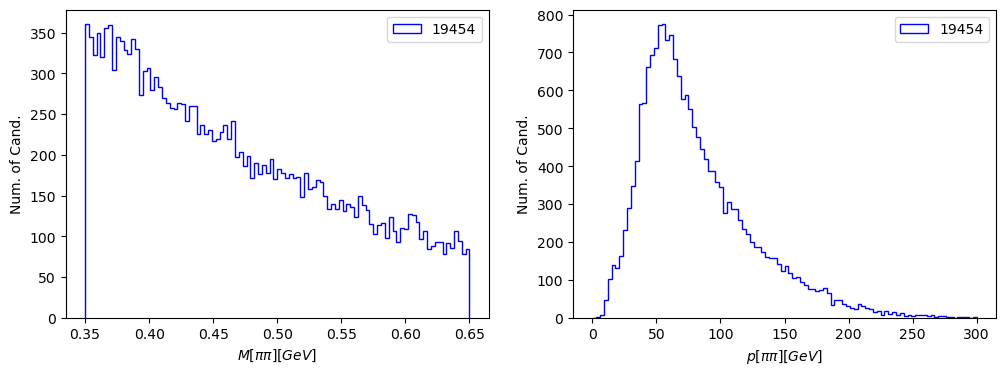

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_os['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("diTracks inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
pipi_p = data_os['dipi_p'][(data_os['dipi_M']>0.35) & (data_os['dipi_M']<0.65)]
ax2.hist(pipi_p,range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("two tracks with pion mass")
npipi = data_os['dipi_M'][(data_os['dipi_M']>0.35) & (data_os['dipi_M']<0.65)]
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_os['dipi_p'][(data_os['dipi_M']>0.35) & (data_os['dipi_M']<0.65)]
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "Trk12_MandP.png",bbox_inches='tight')

/var/folders/v0/m2n9p37j619fdss_7fv_5k700000gn/T/ipykernel_49600/1767238468.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.hist2d(data_os['Vertex_pos.fZ'], data_os['Vertex_pos_R'],bins=100,range=[[95,180],[0,1.2]],norm=mcolors.LogNorm(),**cmap,label="All")


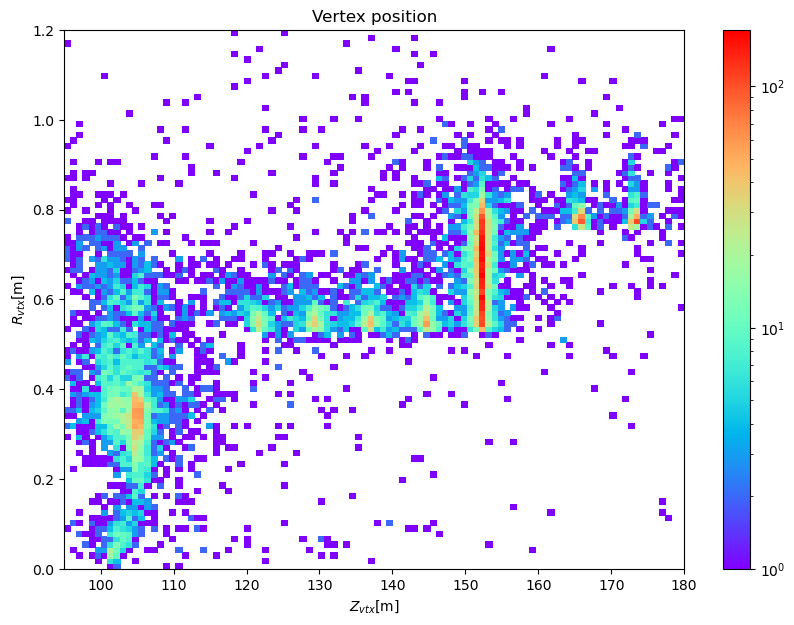

In [38]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os['Vertex_pos.fZ'], data_os['Vertex_pos_R'],bins=100,range=[[95,180],[0,1.2]],norm=mcolors.LogNorm(),**cmap,label="All")
plt.title("Vertex position")
plt.xlabel('$Z_{vtx}$[m]')
plt.ylabel('$R_{vtx}$[m]')
plt.colorbar()
plt.savefig(pathPlots + "vtxPos.png",bbox_inches='tight')

In [39]:
# 0: kIsInSmartFV, 1: kIsLateral, 2: kIsUpstream,
data_os['Vertex_pos_zFV'] = data_os['Vertex_pos.fZ'][data_os['Vertex_type']==0]
data_os['Vertex_pos_rFV'] = data_os['Vertex_pos_R'][data_os['Vertex_type']==0]

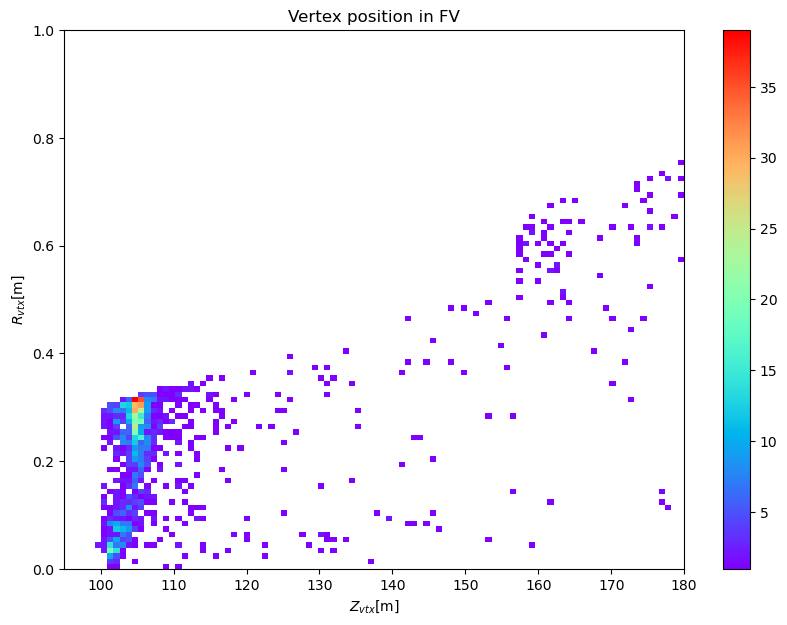

In [40]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os['Vertex_pos_zFV'], data_os['Vertex_pos_rFV'],bins=100,range=[[95,180],[0,1]],**cmap,label="All")
plt.title("Vertex position in FV")
plt.xlabel('$Z_{vtx}$[m]')
plt.ylabel('$R_{vtx}$[m]')
plt.colorbar()
plt.savefig(pathPlots + "vtxPos_FV.png",bbox_inches='tight')

In [41]:
data_os['Track1_posANTI0_xFV'] = data_os['Track1_posANTI0.fX'][data_os['Vertex_type']==0]
data_os['Track1_posANTI0_yFV'] = data_os['Track1_posANTI0.fY'][data_os['Vertex_type']==0]
data_os['Track2_posANTI0_xFV'] = data_os['Track2_posANTI0.fX'][data_os['Vertex_type']==0]
data_os['Track2_posANTI0_yFV'] = data_os['Track2_posANTI0.fY'][data_os['Vertex_type']==0]

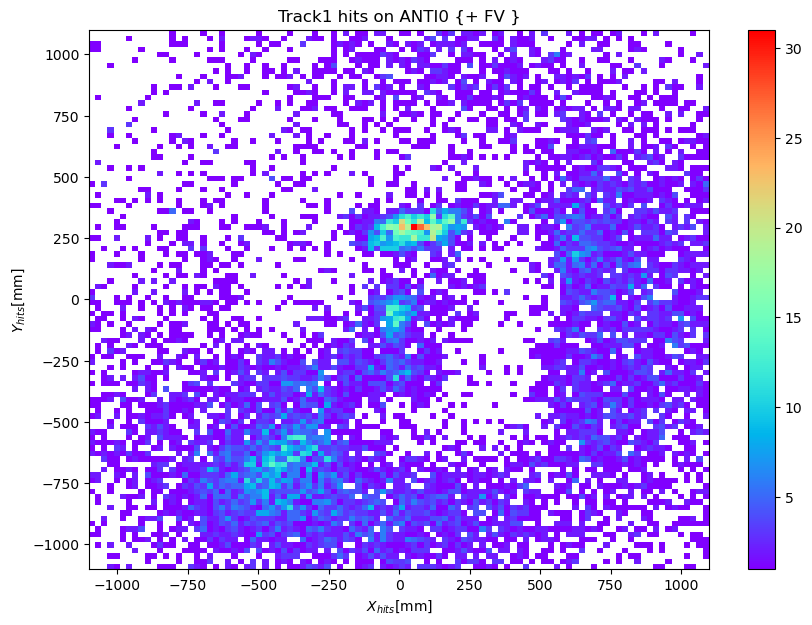

In [42]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os['Track1_posANTI0_xFV'], data_os['Track1_posANTI0_yFV'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track1 hits on ANTI0 {+ FV }")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk1_hitsOnANTI0_FV.png",bbox_inches='tight')

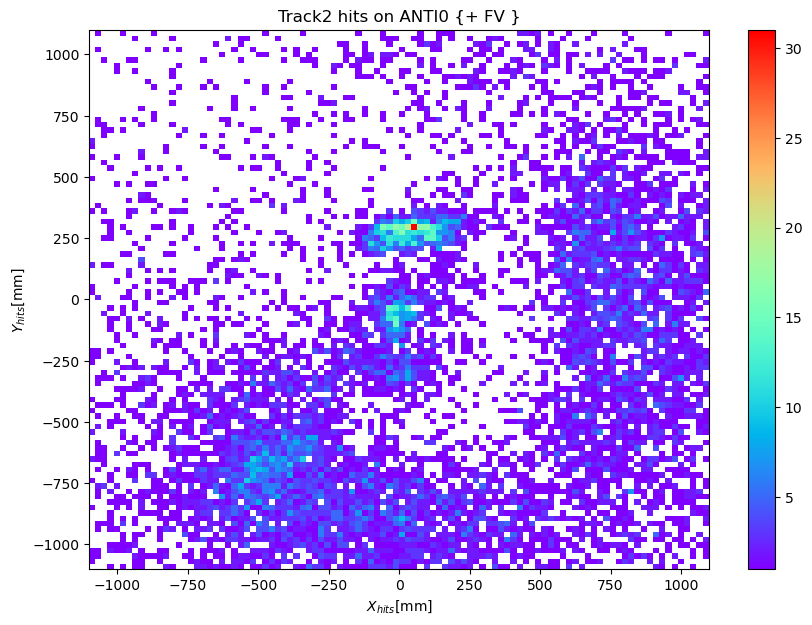

In [43]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os['Track2_posANTI0_xFV'], data_os['Track2_posANTI0_yFV'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track2 hits on ANTI0 {+ FV }")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk2_hitsOnANTI0_FV.png",bbox_inches='tight')

# Two pion invariant mass - check with $0.2\ <\ E_{LKr}/p\ <\ 0.9$

In [44]:
data_os_pipi = data_os[(data_os['Track1_lkrEoP'] > 0.2) & (data_os['Track1_lkrEoP'] < 0.9) & 
                       (data_os['Track2_lkrEoP'] > 0.2) & (data_os['Track2_lkrEoP'] < 0.9)]

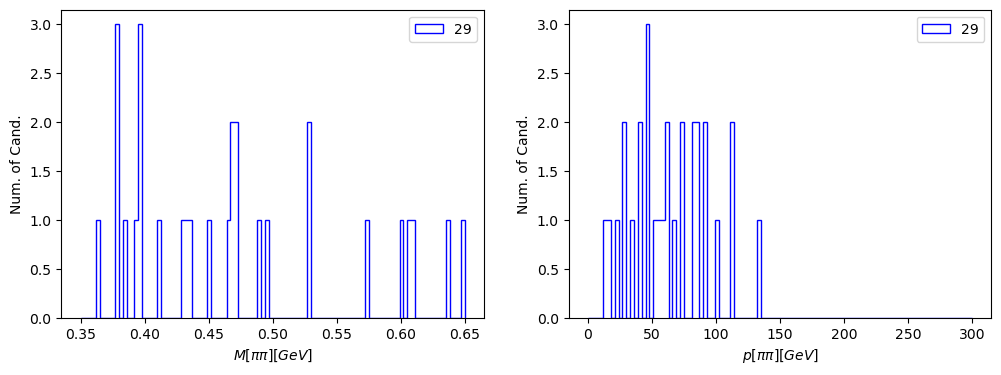

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_os_pipi['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
pipi_p = data_os_pipi['dipi_p'][(data_os_pipi['dipi_M']>0.35) & (data_os_pipi['dipi_M']<0.65)]
ax2.hist(pipi_p,range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("$0.2 < E_{LKr}/p < 0.9$")
npipi = data_os_pipi['dipi_M'][(data_os_pipi['dipi_M']>0.35) & (data_os_pipi['dipi_M']<0.65)]
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_os_pipi['dipi_p'][(data_os_pipi['dipi_M']>0.35) & (data_os_pipi['dipi_M']<0.65)]
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP.png",bbox_inches='tight')

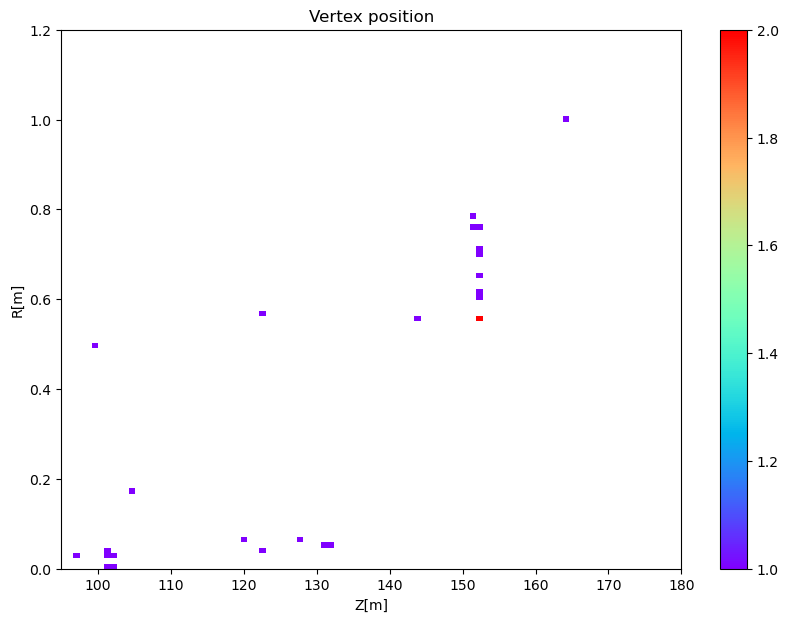

In [46]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os_pipi['Vertex_pos.fZ'], data_os_pipi['Vertex_pos_R'],bins=100,range=[[95,180],[0,1.2]],**cmap,label="All")
plt.title("Vertex position")
plt.xlabel('Z[m]')
plt.ylabel('R[m]')
plt.colorbar()
plt.savefig(pathPlots + "vtxPos_piEoP.png",bbox_inches='tight')

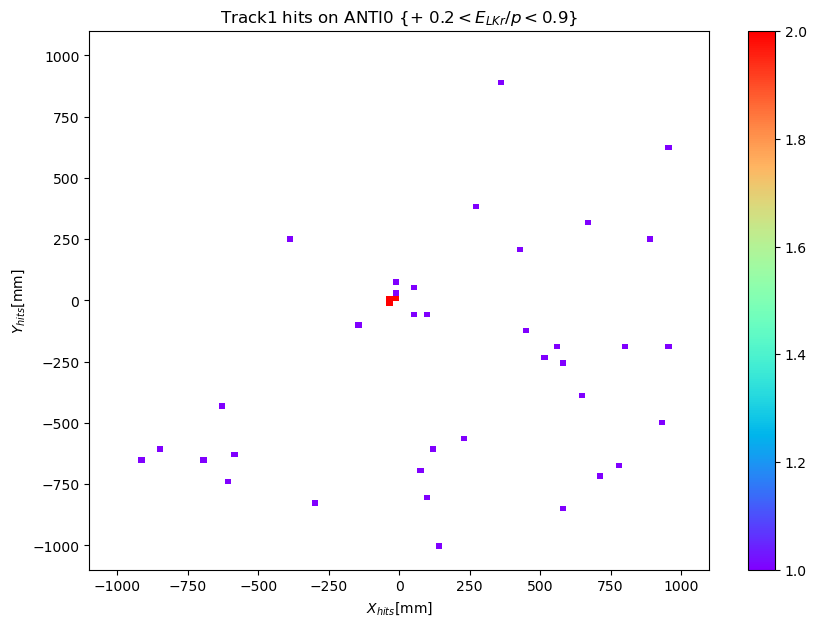

In [47]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os_pipi['Track1_posANTI0.fX'], data_os_pipi['Track1_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track1 hits on ANTI0 {+ $0.2 < E_{LKr}/p < 0.9$}")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk1_hitsOnANTI0_LKrEoP.png",bbox_inches='tight')

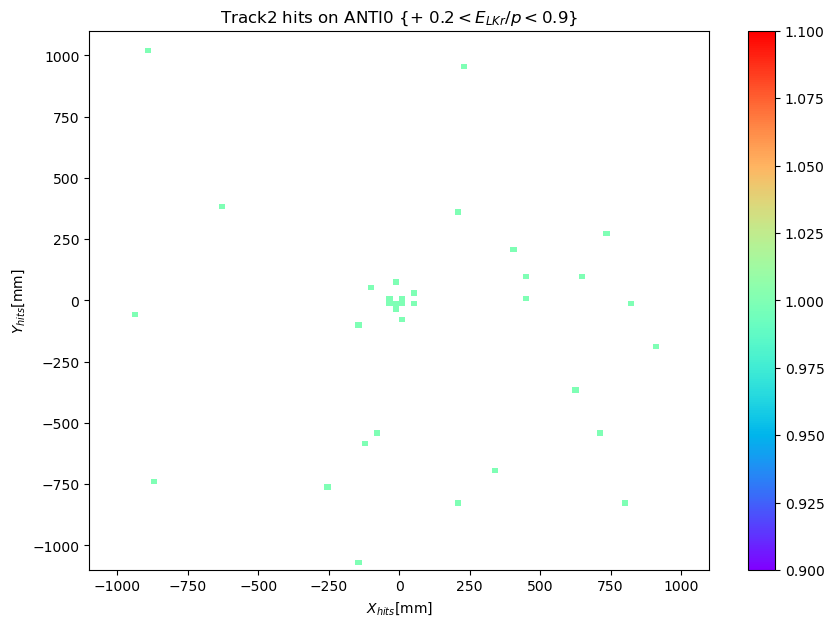

In [48]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os_pipi['Track2_posANTI0.fX'], data_os_pipi['Track2_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track2 hits on ANTI0 {+ $0.2 < E_{LKr}/p < 0.9$}")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk2_hitsOnANTI0_LKrEoP.png",bbox_inches='tight')

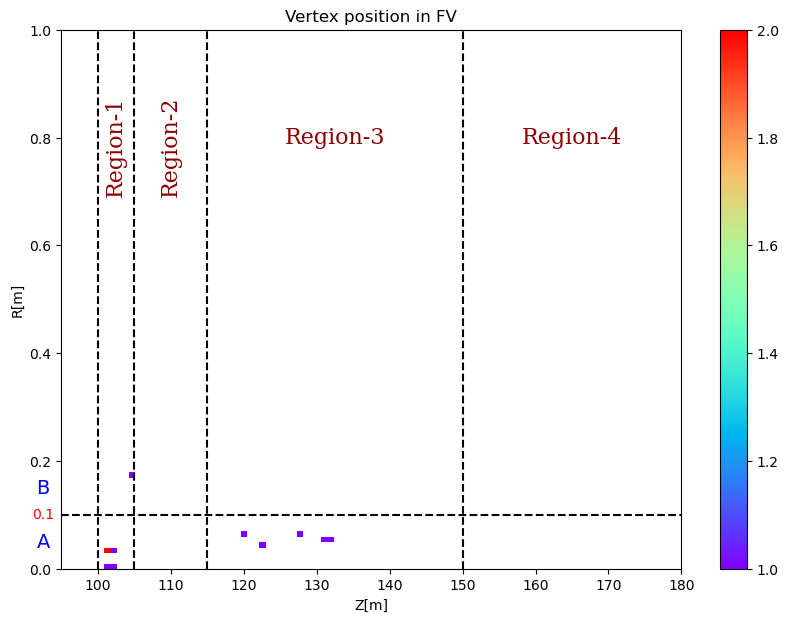

In [49]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_os_pipi['Vertex_pos_zFV'], data_os_pipi['Vertex_pos_rFV'],bins=100,range=[[95,180],[0,1]],**cmap,label="All")
plt.title("Vertex position in FV")
plt.text(102.5, 0.7, "Region-1", fontdict=font,rotation='vertical',ha='center')
plt.text(110, 0.7, "Region-2", fontdict=font,rotation='vertical',ha='center')
plt.text(132.5, 0.8, "Region-3", fontdict=font,rotation='horizontal',ha='center',va='center')
plt.text(165, 0.8, "Region-4", fontdict=font,rotation='horizontal',ha='center',va='center')
plt.text(92.5, 0.1, "0.1",color='red',rotation='horizontal',ha='center',va='center')
plt.text(92.5, 0.05, "A",color='blue',size=14,rotation='horizontal',ha='center',va='center')
plt.text(92.5, 0.15, "B",color='blue',size=14,rotation='horizontal',ha='center',va='center')
plt.xlabel('Z[m]')
plt.ylabel('R[m]')
plt.colorbar()
plt.axhline(y=0.1, color='black', linestyle='--')
plt.axvline(x=100, color='black', linestyle='--')
plt.axvline(x=105, color='black', linestyle='--')
plt.axvline(x=115, color='black', linestyle='--')
plt.axvline(x=150, color='black', linestyle='--')

plt.savefig(pathPlots + "vtxPos_FV_piEoP.png",bbox_inches='tight')

In [50]:
data_pipi_FV = data_os_pipi[(data_os_pipi['Vertex_type']==0) & (data_os_pipi['dipi_M']>0.46) & (data_os_pipi['dipi_M']<0.54)]

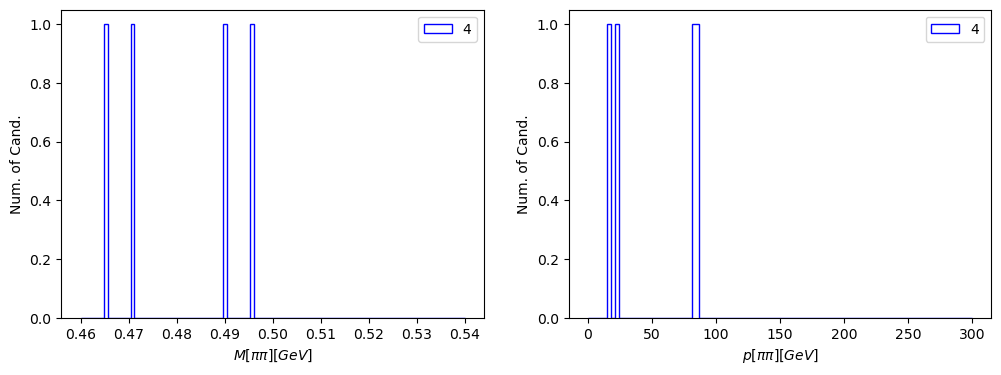

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV['dipi_M'],range=(0.46,0.54),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("$0.2 < E_{LKr}/p < 0.9$")
npipi = data_pipi_FV['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_FV.png",bbox_inches='tight')

In [52]:
data_pipi_FV[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3
0.489679,15.283552,True,True,True,False,False,False,True,True,True,True,True,True
0.470868,84.075541,True,True,True,False,False,False,True,True,True,True,True,False
0.465197,22.593494,True,True,True,True,True,True,True,True,True,True,True,True
0.495877,82.383689,False,True,True,True,False,False,False,True,True,True,False,False


In [53]:
data_pipi_FV[['dipi_M','dipi_p','Vertex_type','Vertex_pos_rFV','Vertex_pos_zFV']]

,dipi_M,dipi_p,Vertex_type,Vertex_pos_rFV,Vertex_pos_zFV
entry,,,,,
259874,0.489679,15.283552,0,0.274284,190.016963
1443903,0.470868,84.075541,0,0.699794,194.161502
1560413,0.465197,22.593494,0,0.422733,181.247782
2114376,0.495877,82.383689,0,0.060789,128.116334


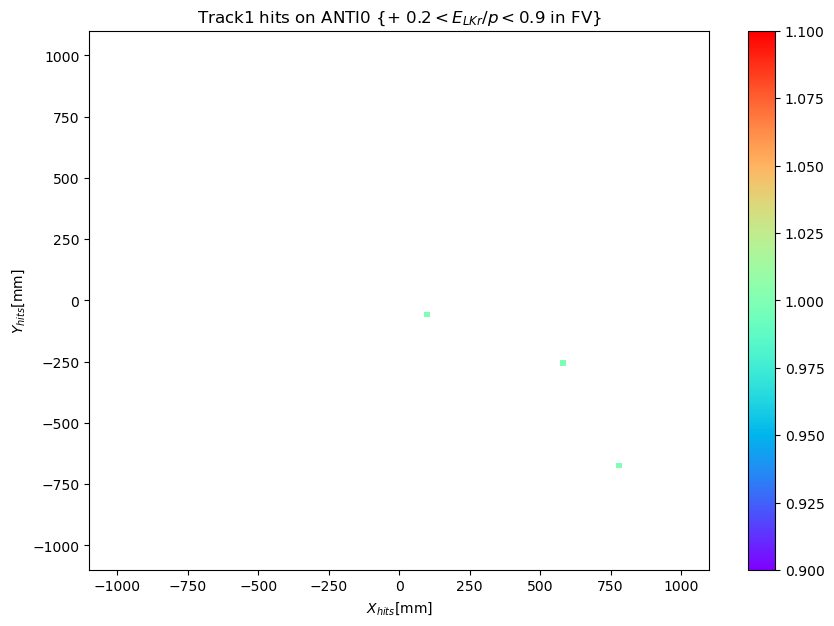

In [54]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_pipi_FV['Track1_posANTI0.fX'], data_pipi_FV['Track1_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track1 hits on ANTI0 {+ $0.2 < E_{LKr}/p < 0.9$ in FV}")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk1_hitsOnANTI0_LKrEoP_FV.png",bbox_inches='tight')

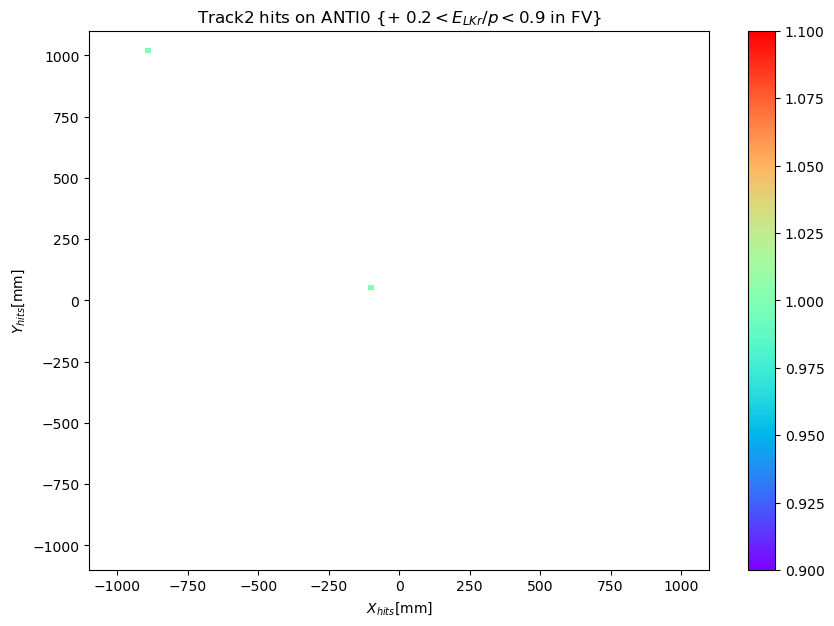

In [55]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_pipi_FV['Track2_posANTI0.fX'], data_pipi_FV['Track2_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track2 hits on ANTI0 {+ $0.2 < E_{LKr}/p < 0.9$ in FV}")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()
plt.savefig(pathPlots + "XvsY_trk2_hitsOnANTI0_LKrEoP_FV.png",bbox_inches='tight')

# In Fiducial Volume:

# - <font size="5">Region 1:</font>

* <font size="4"> $R < 0.1 & 100 < Z < 105$</font>

In [56]:
data_pipi_FV_region1 = data_pipi_FV[(data_pipi_FV['Vertex_pos_rFV'] < 0.1) & (data_pipi_FV['Vertex_pos_zFV'] < 105)]

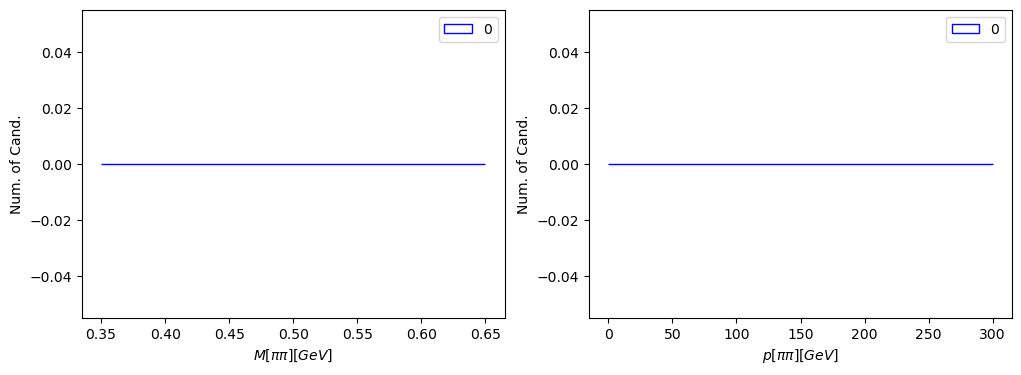

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_region1['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_region1['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R < 0.1 & 100 < Z < 105")
npipi = data_pipi_FV_region1['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_region1['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Reg1a.png",bbox_inches='tight')

In [58]:
data_pipi_FV_region1[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3


* <font size="4"> $R > 0.1 & 100 < Z < 105$</font>

In [59]:
data_pipi_FV_region1_ = data_pipi_FV[(data_pipi_FV['Vertex_pos_rFV'] > 0.1) & (data_pipi_FV['Vertex_pos_zFV'] < 105)]

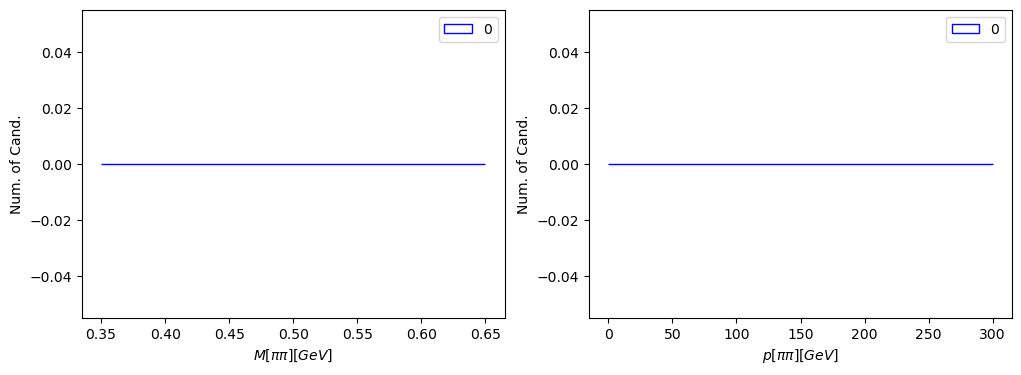

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_region1_['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_region1_['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R > 0.1 & 100 < Z < 105")
npipi = data_pipi_FV_region1_['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_region1_['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Reg1b.png",bbox_inches='tight')

In [61]:
data_pipi_FV_region1_[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3


# - <font size="5">Region 2:</font>

* <font size="4">$R < 0.1 & 105 < Z < 115$</font>

In [62]:
data_pipi_FV_region2 = data_pipi_FV[(data_pipi_FV['Vertex_pos_rFV'] < 0.1) & (data_pipi_FV['Vertex_pos_zFV'] > 105) & (data_pipi_FV['Vertex_pos_zFV'] < 115)]

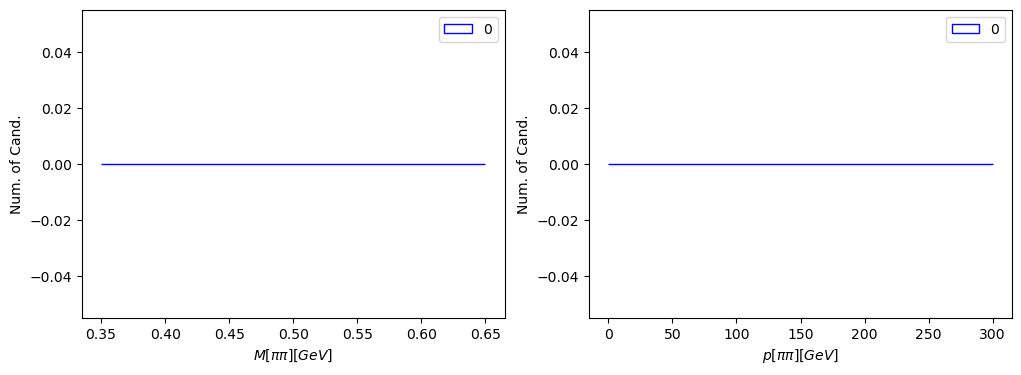

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_region2['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_region2['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R < 0.1 & 105 < Z < 115")
npipi = data_pipi_FV_region2['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_region2['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Reg2a.png",bbox_inches='tight')

In [64]:
data_pipi_FV_region2[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3


* <font size="4">$R > 0.1 & 105 < Z < 115$</font>

In [65]:
data_pipi_FV_region2_ = data_pipi_FV[(data_pipi_FV['Vertex_pos_rFV'] > 0.1) & (data_pipi_FV['Vertex_pos_zFV'] > 105) & (data_pipi_FV['Vertex_pos_zFV'] < 115)]

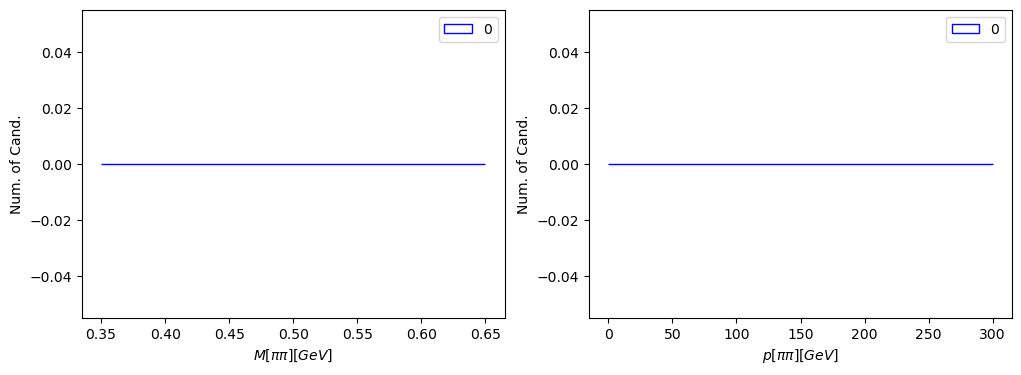

In [66]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_region2_['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_region2_['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R < 0.1 & 105 < Z < 115")
npipi = data_pipi_FV_region2_['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_region2_['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Reg2b.png",bbox_inches='tight')

In [67]:
data_pipi_FV_region2_[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3


# - <font size="5">Region 3:</font>

* <font size="4">$R < 0.1 & 115 < Z < 150$</font>

In [68]:
data_pipi_FV_region3 = data_pipi_FV[(data_pipi_FV['Vertex_pos_rFV'] < 0.1) & (data_pipi_FV['Vertex_pos_zFV'] > 115) & (data_pipi_FV['Vertex_pos_zFV'] < 150)]

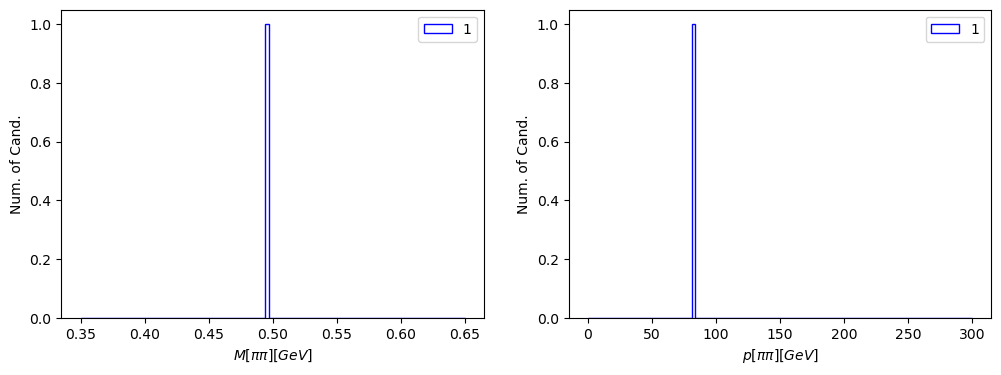

In [69]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_region3['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_region3['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R < 0.1 & 105 < Z < 115")
npipi = data_pipi_FV_region3['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_region3['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Reg3a.png",bbox_inches='tight')

In [70]:
data_pipi_FV_region3[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3
0.495877,82.383689,False,True,True,True,False,False,False,True,True,True,False,False


In [71]:
data_pipi_FV_region3[['dipi_M','dipi_p','Vertex_pos_rFV','Vertex_pos_zFV']].style.hide(axis="index")

dipi_M,dipi_p,Vertex_pos_rFV,Vertex_pos_zFV
0.495877,82.383689,0.060789,128.116334


* <font size="4">$R > 0.1 & 115 < Z < 150$</font>

In [72]:
data_pipi_FV_region3_ = data_pipi_FV[(data_pipi_FV['Vertex_pos_rFV'] > 0.1) & (data_pipi_FV['Vertex_pos_zFV'] > 115) & (data_pipi_FV['Vertex_pos_zFV'] < 150)]

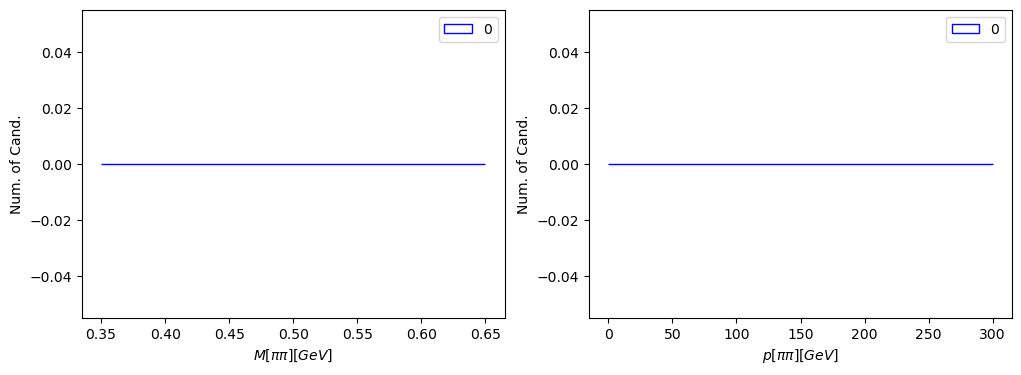

In [73]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_region3_['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_region3_['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R < 0.1 & 105 < Z < 115")
npipi = data_pipi_FV_region3_['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_region3_['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Reg3b.png",bbox_inches='tight')

In [74]:
data_pipi_FV_region3_[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3


# - <font size="5">Region 4:</font>

* <font size="4"> $R < 0.1 & 150 < Z < 180$</font>

In [75]:
data_pipi_FV_region4 = data_pipi_FV[(data_pipi_FV['Vertex_pos_rFV'] < 0.1) & (data_pipi_FV['Vertex_pos_zFV'] > 150) & (data_pipi_FV['Vertex_pos_zFV'] < 180)]

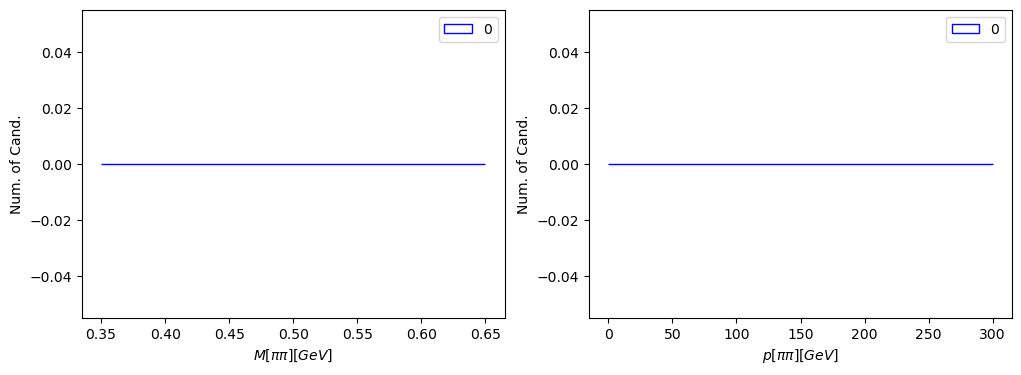

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_region4['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_region4['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R < 0.1 & 150 < Z < 180")
npipi = data_pipi_FV_region4['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_region4['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Reg4a.png",bbox_inches='tight')

In [77]:
data_pipi_FV_region4[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3


* <font size="4"> $R > 0.1 & 150 < Z < 180$</font>

In [78]:
data_pipi_FV_region4_ = data_pipi_FV[(data_pipi_FV['Vertex_pos_rFV'] > 0.1) & (data_pipi_FV['Vertex_pos_zFV'] > 150) & (data_pipi_FV['Vertex_pos_zFV'] < 180)]

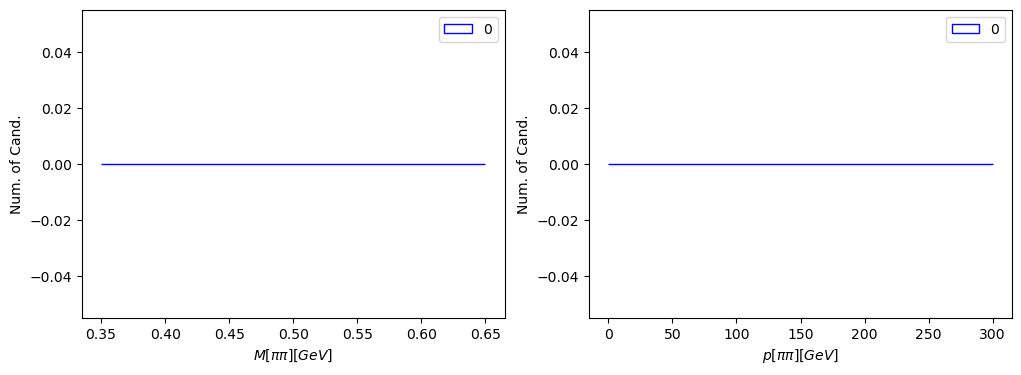

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_region4_['dipi_M'],range=(0.35,0.65),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_region4_['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R > 0.1 & 150 < Z < 180")
npipi = data_pipi_FV_region4_['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_region4_['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Reg4b.png",bbox_inches='tight')

In [80]:
data_pipi_FV_region4_[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3


# Overall check depending the results from 4 regions

In [81]:
massWindow = (data_pipi_FV['dipi_M'] > 0.46) & (data_pipi_FV['dipi_M'] < 0.54)
regs = (data_pipi_FV['Vertex_pos_zFV'] > 100) & (data_pipi_FV['Vertex_pos_zFV'] < 150)

In [82]:
data_pipi_FV_overall = data_pipi_FV[massWindow & regs]

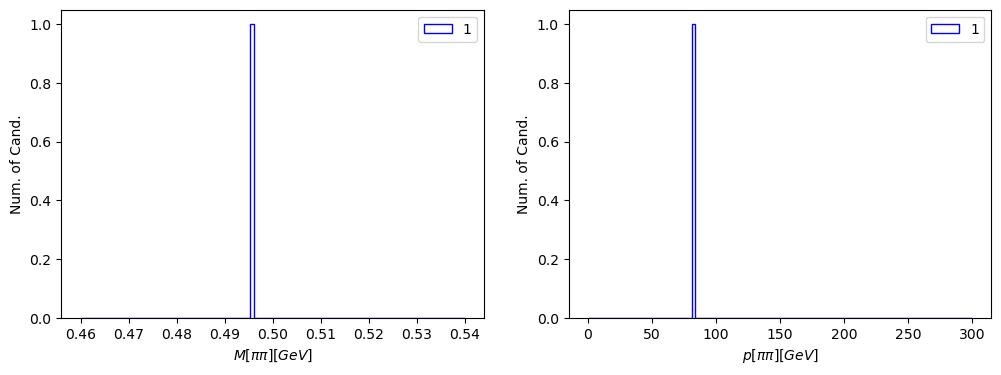

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_overall['dipi_M'],range=(0.46,0.54),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$M[\pi\pi][GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_overall['dipi_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p[\pi\pi][GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R > 0.1 & 150 < Z < 180")
npipi = data_pipi_FV_overall['dipi_M']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_overall['dipi_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "diPi_MandP_Regs.png",bbox_inches='tight')

In [84]:
data_pipi_FV_overall[['dipi_M','dipi_p','pi1_ANTI0','pi1_NewCHOD','pi1_LKr','pi1_MUV1','pi1_MUV2','pi1_MUV3','pi2_ANTI0','pi2_NewCHOD','pi2_LKr','pi2_MUV1','pi2_MUV2','pi2_MUV3']].style.hide(axis="index")

dipi_M,dipi_p,pi1_ANTI0,pi1_NewCHOD,pi1_LKr,pi1_MUV1,pi1_MUV2,pi1_MUV3,pi2_ANTI0,pi2_NewCHOD,pi2_LKr,pi2_MUV1,pi2_MUV2,pi2_MUV3
0.495877,82.383689,False,True,True,True,False,False,False,True,True,True,False,False


In [85]:
data_pipi_FV_overall[['dipi_M','dipi_p','Vertex_pos_rFV','Vertex_pos_zFV']].style.hide(axis="index")

dipi_M,dipi_p,Vertex_pos_rFV,Vertex_pos_zFV
0.495877,82.383689,0.060789,128.116334


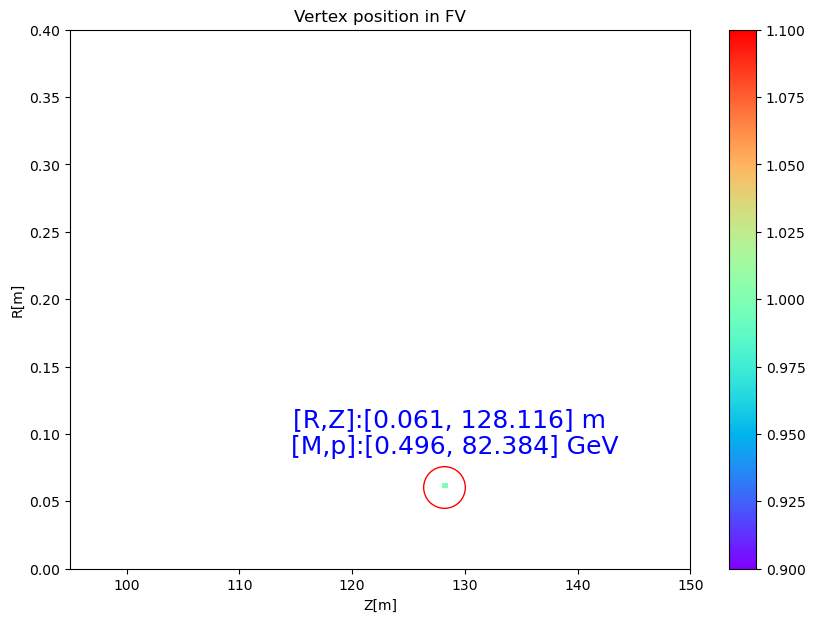

In [86]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_pipi_FV_overall['Vertex_pos_zFV'], data_pipi_FV_overall['Vertex_pos_rFV'],bins=100,range=[[95,150],[0,0.4]],**cmap,label="All")
plt.title("Vertex position in FV")
plt.xlabel('Z[m]')
plt.ylabel('R[m]')
plt.colorbar()
tM1=str(data_pipi_FV_overall[['dipi_M']][:1].round(3).values).replace("[","").replace("]","")
tp1=str(data_pipi_FV_overall[['dipi_p']][:1].round(3).values).replace("[","").replace("]","")
text1="[M,p]:["+tM1+", "+tp1+"] GeV"
plt.text(data_pipi_FV_overall['Vertex_pos_zFV'][:1]+1, 
         data_pipi_FV_overall['Vertex_pos_rFV'][:1]+0.03, 
         text1 ,color='blue',size=18,
         rotation='horizontal',ha='center',va='center')
tM2=str(data_pipi_FV_overall[['Vertex_pos_rFV']][:1].round(3).values).replace("[","").replace("]","")
tp2=str(data_pipi_FV_overall[['Vertex_pos_zFV']][:1].round(3).values).replace("[","").replace("]","")
text2="[R,Z]:["+tM2+", "+tp2+"] m"
plt.text(data_pipi_FV_overall['Vertex_pos_zFV'][:1]+0.5, 
         data_pipi_FV_overall['Vertex_pos_rFV'][:1]+0.05, 
         text2 ,color='blue',size=18,
         rotation='horizontal',ha='center',va='center')

plt.plot(data_pipi_FV_overall['Vertex_pos_zFV'],data_pipi_FV_overall['Vertex_pos_rFV'],'o', ms=30, mec='red',mfc='none')
plt.savefig(pathPlots + "vtxPos_Regs.png",bbox_inches='tight')

In [87]:
data_pipi_FV_overall.loc[data_pipi_FV_overall['Track1_charge']==+1, 'piplus_p']   = data_pipi_FV_overall['Track1_p']
data_pipi_FV_overall.loc[data_pipi_FV_overall['Track2_charge']==+1, 'piplus_p']   = data_pipi_FV_overall['Track2_p']
data_pipi_FV_overall.loc[data_pipi_FV_overall['Track1_charge']==-1, 'piminus_p']  = data_pipi_FV_overall['Track1_p']
data_pipi_FV_overall.loc[data_pipi_FV_overall['Track2_charge']==-1, 'piminus_p']  = data_pipi_FV_overall['Track2_p']

/var/folders/v0/m2n9p37j619fdss_7fv_5k700000gn/T/ipykernel_49600/2355776746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pipi_FV_overall.loc[data_pipi_FV_overall['Track1_charge']==+1, 'piplus_p']   = data_pipi_FV_overall['Track1_p']
/var/folders/v0/m2n9p37j619fdss_7fv_5k700000gn/T/ipykernel_49600/2355776746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pipi_FV_overall.loc[data_pipi_FV_overall['Track2_charge']==+1, 'piplus_p']   = data_pipi_FV_overall['Track2_p']
/var/folders/v0/m2n9p3

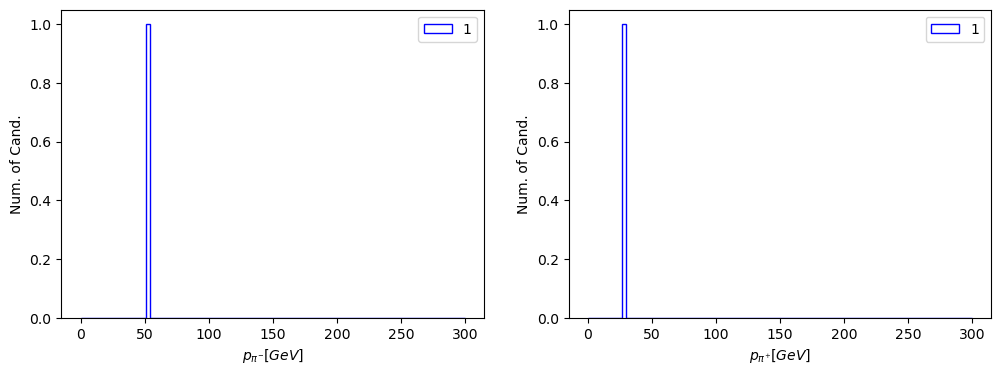

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(data_pipi_FV_overall['piminus_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax1.set_title("dipion inv. mass")
ax1.set_xlabel('$p_{\pi^{-}}[GeV]$')
ax1.set_ylabel('Num. of Cand.')
ax2.hist(data_pipi_FV_overall['piplus_p'],range=(0,300),bins=100,log=False, color='blue', histtype='step')
#ax2.set_title("dipion momentum")
ax2.set_xlabel('$p_{\pi^{+}}[GeV]$')
ax2.set_ylabel('Num. of Cand.')
#fig.suptitle("R < 0.1 & 100 < Z < 105")
npipi = data_pipi_FV_overall['piminus_p']
npipi = str(len(npipi))
legend1 = ax1.legend([npipi],loc=1)
npipi = data_pipi_FV_overall['piplus_p']
npipi = str(len(npipi))
legend1 = ax2.legend([npipi],loc=1)
plt.savefig(pathPlots + "pis_p_Regs_overall.png",bbox_inches='tight')

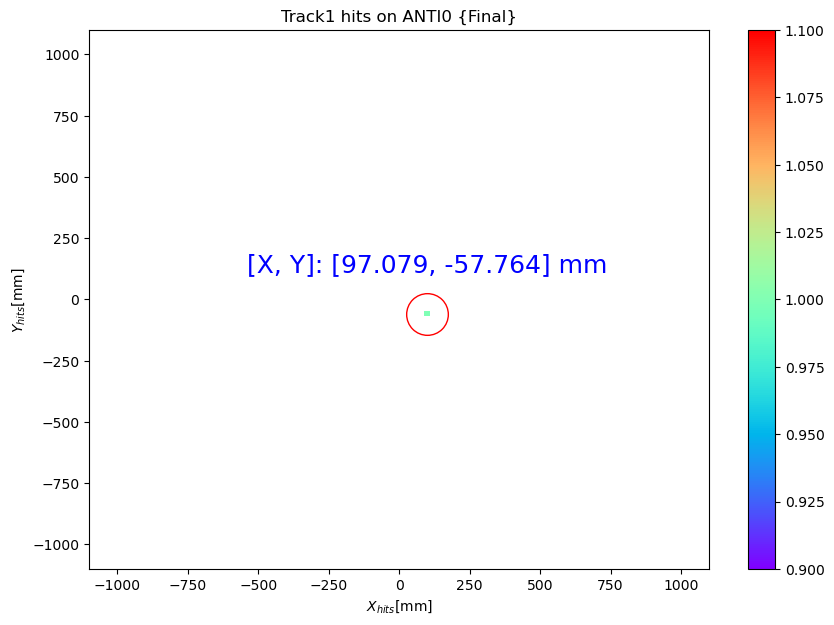

In [89]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_pipi_FV_overall['Track1_posANTI0.fX'], data_pipi_FV_overall['Track1_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track1 hits on ANTI0 {Final}")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()

tM1=str(data_pipi_FV_overall[['Track1_posANTI0.fX']][:1].round(3).values).replace("[","").replace("]","")
tp1=str(data_pipi_FV_overall[['Track1_posANTI0.fY']][:1].round(3).values).replace("[","").replace("]","")
text1="[X, Y]: ["+tM1+", "+tp1+"] mm"
plt.text(data_pipi_FV_overall['Track1_posANTI0.fX'][:1]+1, 
         data_pipi_FV_overall['Track1_posANTI0.fY'][:1]+200, 
         text1 ,color='blue',size=18,
         rotation='horizontal',ha='center',va='center')

plt.plot(data_pipi_FV_overall['Track1_posANTI0.fX'],data_pipi_FV_overall['Track1_posANTI0.fY'],'o', ms=30, mec='red',mfc='none')

plt.savefig(pathPlots + "XvsY_trk1_hitsOnANTI0_Final.png",bbox_inches='tight')

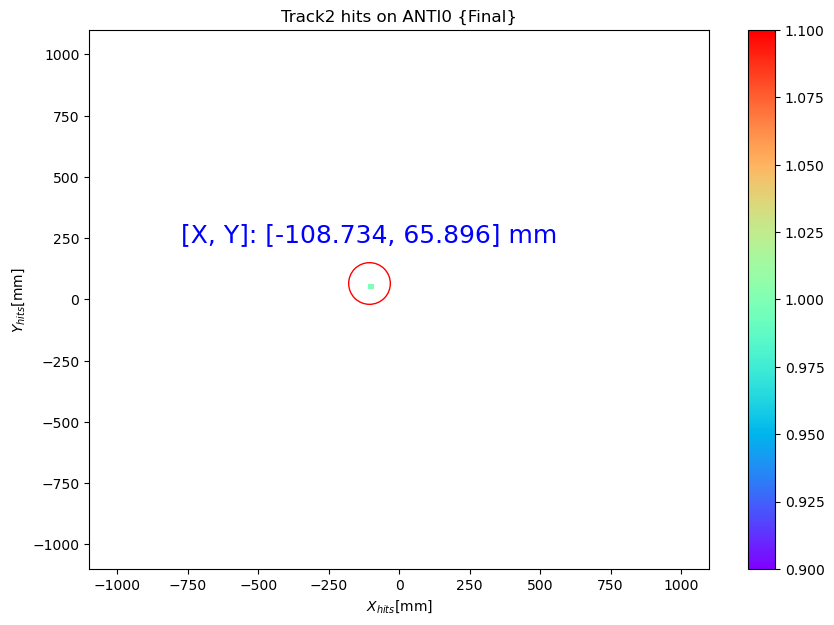

In [90]:
plt.figure(figsize=(10,7))
cmap = copy.copy(plt.cm.get_cmap('rainbow'))
cmap.set_under('white')
cmap = dict(cmap=cmap, vmin=1)
plt.hist2d(data_pipi_FV_overall['Track2_posANTI0.fX'], data_pipi_FV_overall['Track2_posANTI0.fY'],bins=100,range=[[-1100,1100],[-1100,1100]],**cmap,label="All")
plt.title("Track2 hits on ANTI0 {Final}")
plt.xlabel('$X_{hits}$[mm]')
plt.ylabel('$Y_{hits}$[mm]')
plt.colorbar()

tM1=str(data_pipi_FV_overall[['Track2_posANTI0.fX']][:1].round(3).values).replace("[","").replace("]","")
tp1=str(data_pipi_FV_overall[['Track2_posANTI0.fY']][:1].round(3).values).replace("[","").replace("]","")
text1="[X, Y]: ["+tM1+", "+tp1+"] mm"
plt.text(data_pipi_FV_overall['Track2_posANTI0.fX'][:1]+1, 
         data_pipi_FV_overall['Track2_posANTI0.fY'][:1]+200, 
         text1 ,color='blue',size=18,
         rotation='horizontal',ha='center',va='center')

plt.plot(data_pipi_FV_overall['Track2_posANTI0.fX'],data_pipi_FV_overall['Track2_posANTI0.fY'],'o', ms=30, mec='red',mfc='none')

plt.savefig(pathPlots + "XvsY_trk2_hitsOnANTI0_Final.png",bbox_inches='tight')